Setup & Imports
You'll need to log into huggingface and accept the terms of the licence for this model - see the model card for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 59.0 MB/s eta 0:00:00


In [2]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
! mkdir "/root/.huggingface"

In [5]:
! cp "drive/MyDrive/.huggingface/token" /root/.huggingface/token

In [6]:
from base64 import b64encode

import numpy
import os
import torch

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
import torch.nn.functional as F
from transformers import logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
torch.cuda.is_available()

True

In [8]:
# Load the pre-trained ViT model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

# Define preprocessing pipeline for images
transform = tfms.Compose([
    tfms.Resize(256),
    tfms.CenterCrop(224),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 146MB/s]


The Autoencoder (AE)
The AE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [9]:
data_path = '/content/drive/MyDrive/expa/mini_mini_imagenet_data/mini_mini_imagenet'

In [10]:
%ls /content/drive/MyDrive/expa/mini_mini_imagenet_data/


image_index_ids.pkl    image_test_ids.pkl       vit_image_test_ids.pkl
image_index.index      mini_mini_imagenet/
image_index_vit.index  vit_image_index_ids.pkl


In [11]:
# generate index
import numpy as np
import faiss
import pickle

In [12]:
index = faiss.IndexFlatL2(384)

In [13]:
id_index = faiss.IndexIDMap(index)

In [14]:
test_ids, index_ids = {}, {}

In [33]:
id = 0
with torch.no_grad():
  for file_name in os.listdir(data_path):
      file_path = os.path.join(data_path, file_name)
      try:
          # Open the image file with PIL
          # print(file_path)
          img = Image.open(file_path)
          # print(img.format)
          if img.format in ("JPEG","JPG") and img.mode == "RGB":
            # img.show()
            # encoded = torch.flatten(pil_to_latent(img.resize((512, 512))))
            # print(encoded.shape)
            if id % 10 == 0:
              test_ids[id] = file_name
            else:
              index_ids[id] = file_name
              img = transform(img).unsqueeze(0)
              encoded = model(img).squeeze().reshape(1, -1)
              # print(encoded.shape)

              id_index.add_with_ids(encoded.cpu(), np.array(id))
              # break
            id += 1
      except IOError:
          print(f"Error opening file: {file_path}")
          continue

KeyboardInterrupt: ignored

In [37]:
faiss.write_index(id_index, '/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_vit.index')


In [38]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_test_ids.pkl', 'wb') as f:
  pickle.dump(test_ids, f)

In [39]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_index_ids.pkl', 'wb') as f:
  pickle.dump(index_ids, f)

In [15]:
id_index = faiss.read_index('/content/drive/MyDrive/expa/mini_mini_imagenet_data/image_index_vit.index')


In [16]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_test_ids.pkl', 'rb') as f:
  test_ids = pickle.load(f)

In [17]:
with open('/content/drive/MyDrive/expa/mini_mini_imagenet_data/vit_image_index_ids.pkl', 'rb') as f:
  index_ids = pickle.load(f)

In [18]:
len(test_ids)

712

In [19]:
len(index_ids)

6408

In [20]:
test_ids

{0: 'n02443484_9191.JPEG',
 10: 'n02966193_41482.JPEG',
 20: 'n02747177_27716.JPEG',
 30: 'n04596742_4211.JPEG',
 40: 'n04296562_27640.JPEG',
 50: 'n02747177_27827.JPEG',
 60: 'n04596742_29015.JPEG',
 70: 'n01843383_5928.JPEG',
 80: 'n04596742_32778.JPEG',
 90: 'n01843383_6061.JPEG',
 100: 'n02443484_11967.JPEG',
 110: 'n04596742_3197.JPEG',
 120: 'n02443484_14163.JPEG',
 130: 'n01843383_3857.JPEG',
 140: 'n04296562_35084.JPEG',
 150: 'n02443484_3181.JPEG',
 160: 'n02443484_1302.JPEG',
 170: 'n04296562_18059.JPEG',
 180: 'n01843383_6960.JPEG',
 190: 'n02747177_22138.JPEG',
 200: 'n04596742_23006.JPEG',
 210: 'n02747177_21929.JPEG',
 220: 'n02747177_23333.JPEG',
 230: 'n01843383_5693.JPEG',
 240: 'n04296562_20540.JPEG',
 250: 'n01843383_5768.JPEG',
 260: 'n04296562_54927.JPEG',
 270: 'n04596742_10.JPEG',
 280: 'n04515003_37225.JPEG',
 290: 'n02110063_7327.JPEG',
 300: 'n04389033_2014.JPEG',
 310: 'n04389033_2557.JPEG',
 320: 'n04515003_6110.JPEG',
 330: 'n02871525_13181.JPEG',
 340: 'n0

In [35]:
test_img = test_ids[4610]
print(test_img)

n02105505_3818.JPEG


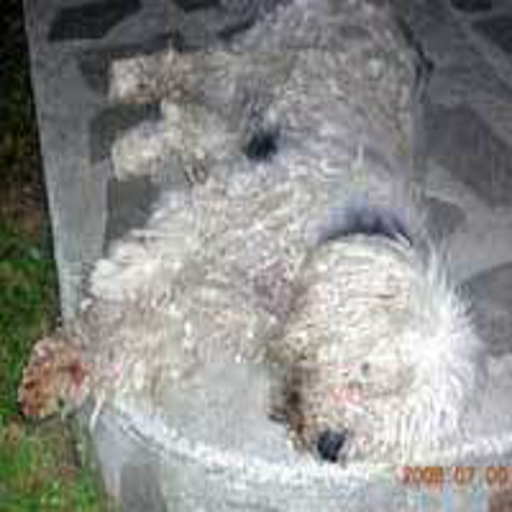

In [36]:
img = Image.open(os.path.join(data_path, str(test_img))).resize((512, 512))
img.show()

In [37]:
with torch.no_grad():
  img = transform(img).unsqueeze(0)
  encoded = model(img).squeeze().reshape(1, -1)

In [38]:
encoded.shape


torch.Size([1, 384])

In [39]:
# Query the index for the k most similar encodings to a given query encoding
k = 30
distances, indices = id_index.search(encoded.cpu(), k)


In [40]:
print(indices)

[[4685 4691 4434 4418 4536 4705 4587 4811 4477 4818 4456 4723 4398 4431
  4768 7077 4485 4452 4844 4757 4353 4624 4614 4493 4585 4674 7069 4773
  4687 4628]]


In [41]:
print(distances)

[[ 8429.369  8852.286  8998.969  9307.252  9392.429  9569.746  9669.641
   9671.006  9727.878  9789.154  9927.165  9968.271 10008.765 10156.111
  10211.99  10259.123 10261.715 10316.816 10339.229 10369.41  10405.258
  10416.09  10496.592 10537.102 10666.201 10672.553 10674.856 10701.645
  10825.37  10855.52 ]]


n02105505_5800.JPEG


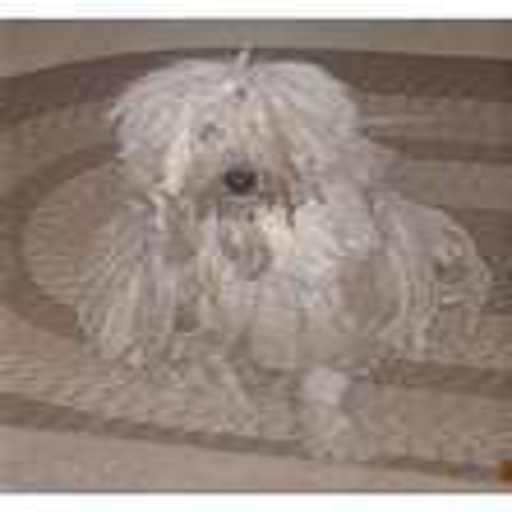

In [42]:
match_img = index_ids[indices[0][0]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

n02105505_78.JPEG


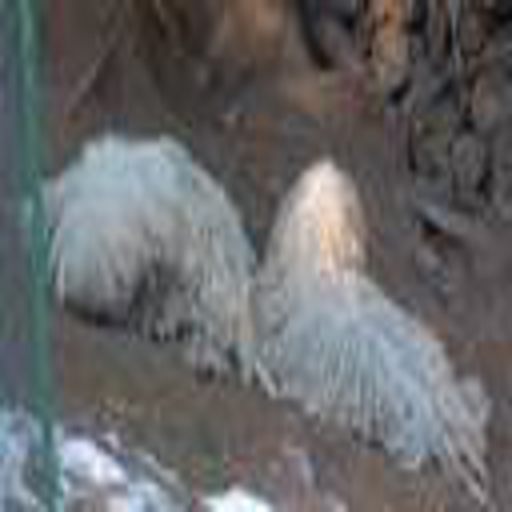

In [43]:
match_img = index_ids[indices[0][1]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

n02105505_3406.JPEG


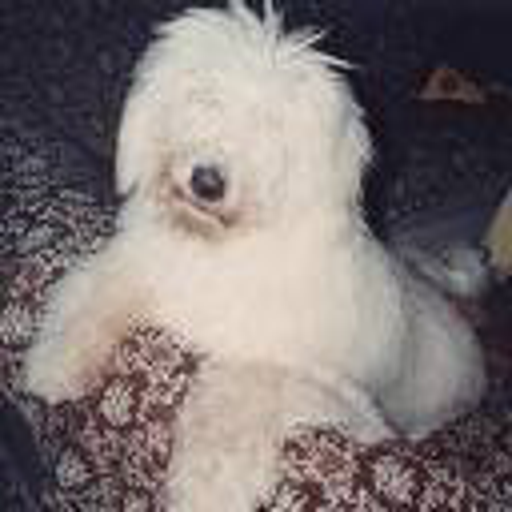

In [44]:
match_img = index_ids[indices[0][2]]
print(match_img)
img = Image.open(os.path.join(data_path, match_img)).resize((512, 512))
img

# New Section